In [1]:
# Parse a text file (nyc_flood_loss_10000_realistic.txt) of synthetic CAT event catelogue such 
# that they become nice and neat dataframe as seen in [3]. This step already generates the 
# nyc_flood_loss_10000_realistic.csv
!python /Users/dantsai/python-notebooks/ATBS/Chapter7_mini_project/cat_model_parser.py


Saved structured loss data to /Users/dantsai/python-notebooks/ATBS/Chapter7_mini_project/nyc_flood_loss_10000_realistic.csv


In [2]:

# Script to process CAT model reports: extract, analyze, and visualize

import re
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# 1. Create DataFrame

df = pd.read_csv("/Users/dantsai/python-notebooks/ATBS/Chapter7_mini_project/nyc_flood_loss_10000_realistic.csv")
print(df.head())
print(df.shape)

  Event ID        Date      City    ZIP  Latitude  Longitude Hazard Type  \
0  EVT4000  2023-09-10  New York  11519   40.7178   -74.0074         FLD   
1  EVT4000  2023-09-10  New York  11509   40.7286   -73.9983         FLD   
2  EVT4000  2023-09-10  New York  11210   40.7082   -74.0107         FLD   
3  EVT4000  2023-09-10  New York  10448   40.7027   -74.0029         FLD   
4  EVT4000  2023-09-10  New York  11150   40.7135   -74.0202         FLD   

    Time                                      Policyholders Claim References  \
0  08:15             Scott Cline, Carlos Wyatt, Jacob James         CLM20000   
1  03:43  Russell Miller, Thomas Padilla, Kathy Spears, ...         CLM20003   
2  13:02  Terry Perez, Andrew Russo, Anne Baker, Jodi Ba...         CLM20006   
3  07:32               Emma King, Manuel Price, James Potts         CLM20009   
4  06:45  Charles Kirby, Kelly Hill, Kara Reynolds, Kimb...         CLM20012   

   Building Loss  Contents Loss  Basement/Foundation Loss  \
0

In [4]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import numpy as np
from rasterio.transform import from_origin
from rasterio.plot import show
!pip install matplotlib-scalebar

In [5]:
# Convert to GeoDataFrame
geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')
gdf = gdf.to_crs(epsg=3857)  # For basemap / metric coordinates


In [6]:
# Load MODZCTA Shapefile

import geopandas as gpd

# Update the path to where your .geojson file is stored
zip_geojson_path = "/Users/dantsai/python-notebooks/ATBS/Chapter7_mini_project/archive/nyc-zip-code-tabulation-areas-polygons.geojson"  # Replace with your actual path

# Load the GeoJSON as a GeoDataFrame
zip_gdf = gpd.read_file(zip_geojson_path)

# Ensure both ZIP zones and loss points use same CRS
zip_gdf = zip_gdf.to_crs(epsg=3857)  # Web Mercator for plotting

# Preview
print(zip_gdf.head())
print(zip_gdf.crs)


   OBJECTID postalCode          PO_NAME STATE borough ST_FIPS CTY_FIPS  \
0         1      11372  Jackson Heights    NY  Queens      36      081   
1         2      11004        Glen Oaks    NY  Queens      36      081   
2         3      11040    New Hyde Park    NY  Queens      36      081   
3         4      11426        Bellerose    NY  Queens      36      081   
4         5      11365    Fresh Meadows    NY  Queens      36      081   

   BLDGpostalCode    Shape_Leng    Shape_Area  \
0               0  20624.692317  2.016328e+07   
1               0  23002.816039  2.260653e+07   
2               0  15749.161511  6.269333e+06   
3               0  35932.810639  4.941836e+07   
4               0  38693.565676  6.938587e+07   

                                                 @id  \
0  http://nyc.pediacities.com/Resource/PostalCode...   
1  http://nyc.pediacities.com/Resource/PostalCode...   
2  http://nyc.pediacities.com/Resource/PostalCode...   
3  http://nyc.pediacities.com/Resour

In [7]:
# 🔁 Choose which column to visualize
loss_column = "Total Loss"  # Or 'Building Loss', 'Contents Loss', 'Basement/Foundation Loss', 'Elevator/Utility Loss', 'Total Loss'


In [8]:
%pip install contextily

Note: you may need to restart the kernel to use updated packages.


In [9]:
from shapely.geometry import Point
import pandas as pd

loss_df = pd.read_csv("/Users/dantsai/python-notebooks/ATBS/Chapter7_mini_project/nyc_flood_loss_10000_realistic.csv")
geometry = [Point(xy) for xy in zip(loss_df["Longitude"], loss_df["Latitude"])]
gdf = gpd.GeoDataFrame(loss_df, geometry=geometry, crs="EPSG:4326")
gdf = gdf.to_crs(epsg=3857)


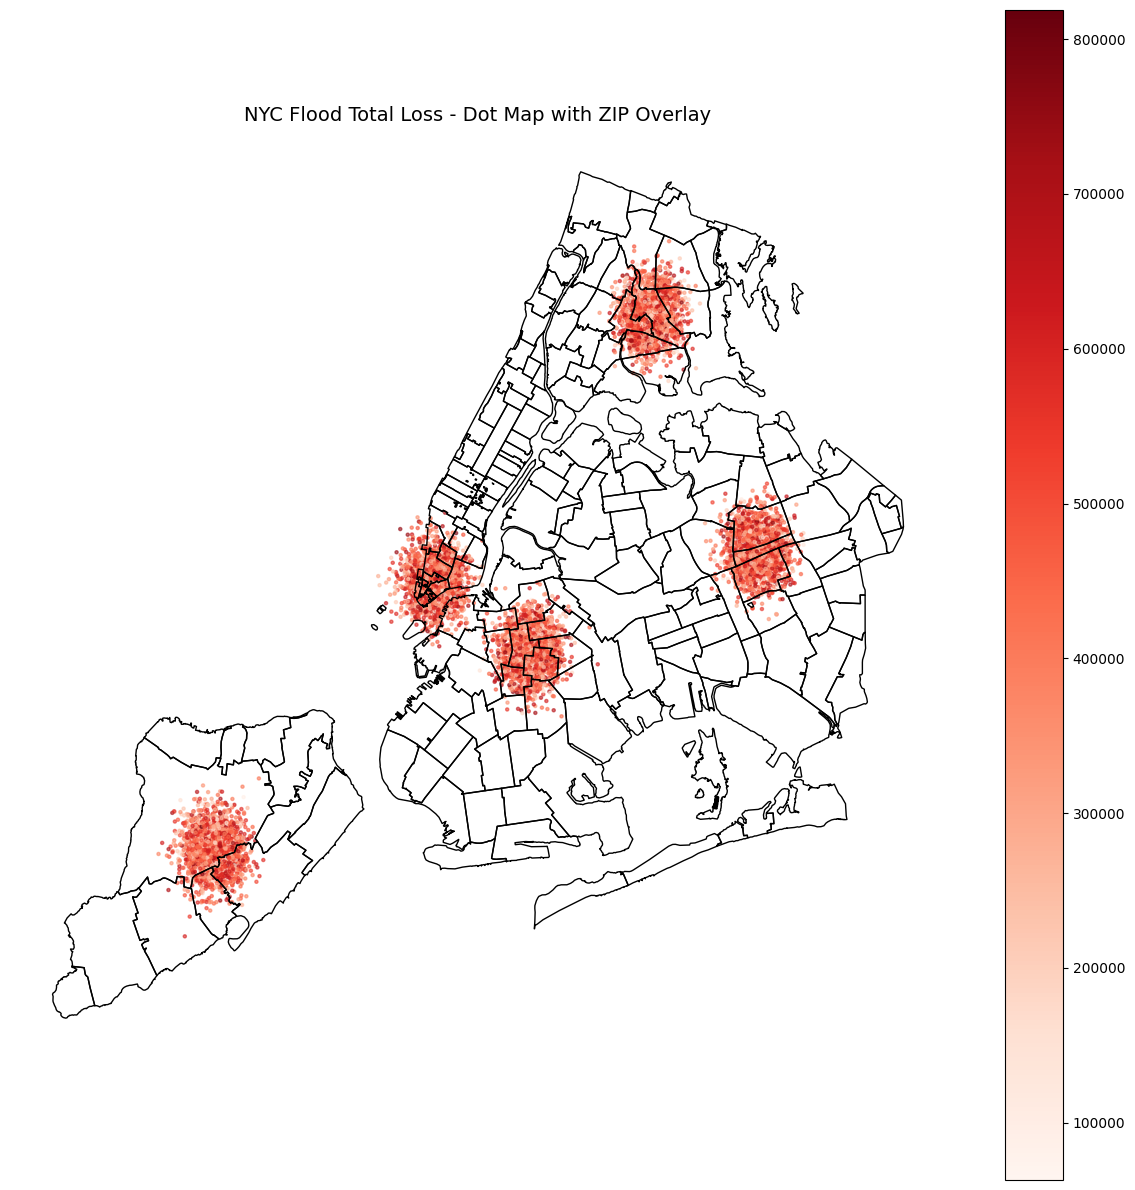

In [10]:
# --- (1) DOT MAP ---
import matplotlib.pyplot as plt

loss_column = "Total Loss"

fig, ax = plt.subplots(figsize=(12, 12))

# Plot ZIP boundaries
zip_gdf.boundary.plot(ax=ax, linewidth=1, edgecolor="black")

# Plot loss dots
gdf.plot(ax=ax, column=loss_column, cmap='Reds', markersize=5, alpha=0.6, legend=True)

ax.set_title(f"NYC Flood {loss_column} - Dot Map with ZIP Overlay", fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()


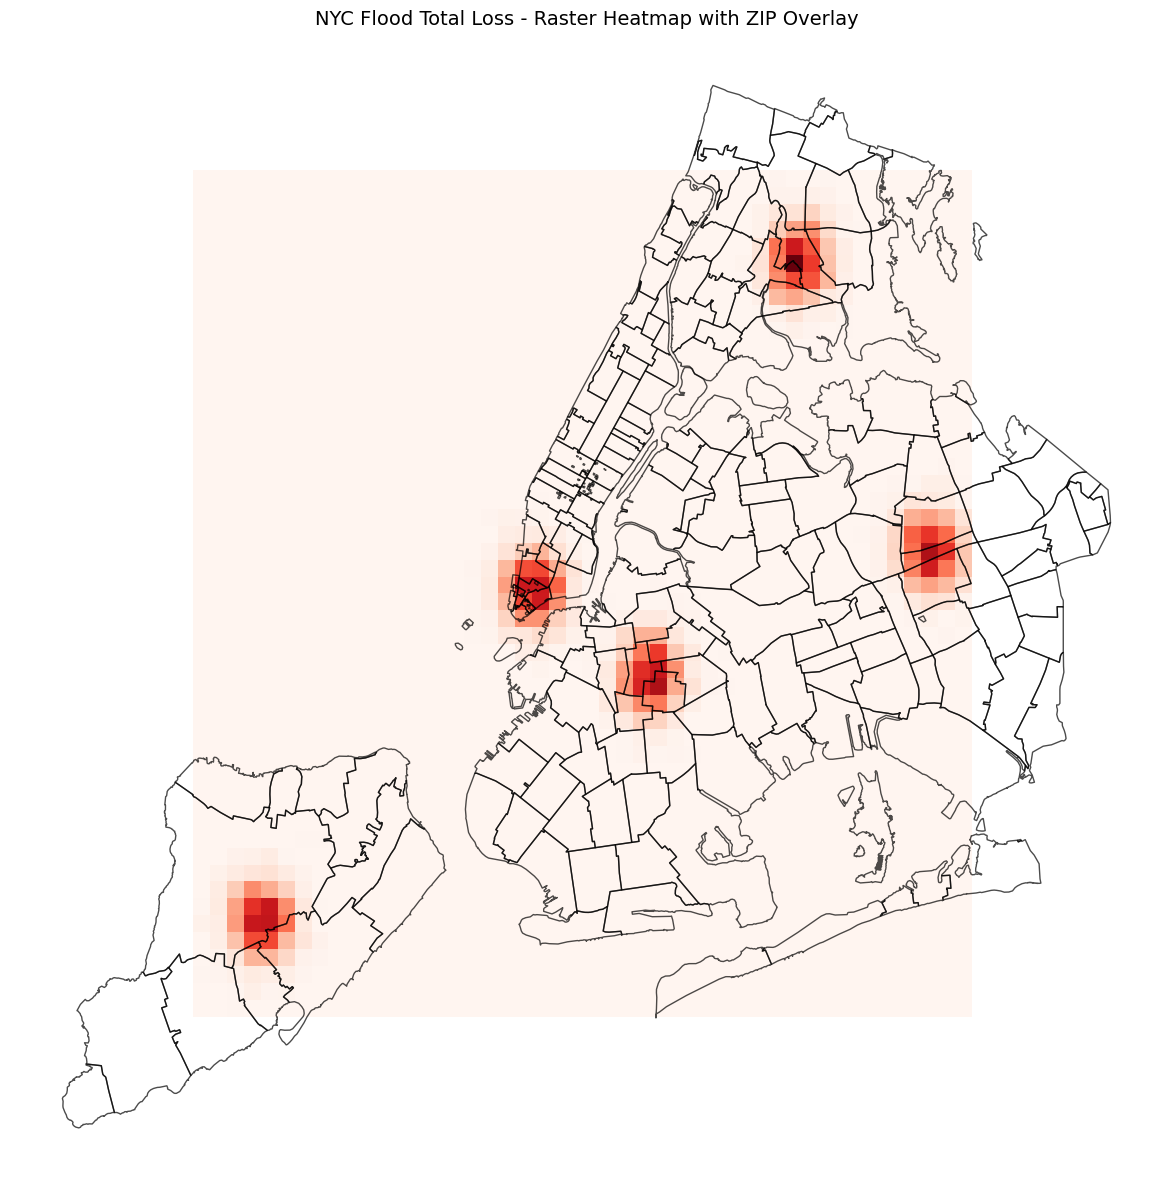

In [11]:
# --- (2) RASTER MAP --- (aggregated losses per grid cell)
import numpy as np
from rasterio.transform import from_origin
from rasterio.plot import show

# Set raster resolution (1 km grid)
resolution = 1000
xmin, ymin, xmax, ymax = gdf.total_bounds
width = int((xmax - xmin) / resolution)
height = int((ymax - ymin) / resolution)
raster = np.zeros((height, width))

# Aggregate raster by summing losses into grid cells
for _, row in gdf.iterrows():
    col = int((row.geometry.x - xmin) / resolution)
    row_idx = int((ymax - row.geometry.y) / resolution)
    if 0 <= col < width and 0 <= row_idx < height:
        raster[row_idx, col] += row[loss_column]

# Plot raster with ZIP outlines
transform = from_origin(xmin, ymax, resolution, resolution)
fig, ax = plt.subplots(figsize=(12, 12))

# Show raster heatmap
show(raster, transform=transform, ax=ax, cmap='Reds')

# Overlay ZIP outlines
zip_gdf.boundary.plot(ax=ax, linewidth=1, edgecolor="black", alpha=0.7)

ax.set_title(f"NYC Flood {loss_column} - Raster Heatmap with ZIP Overlay", fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()


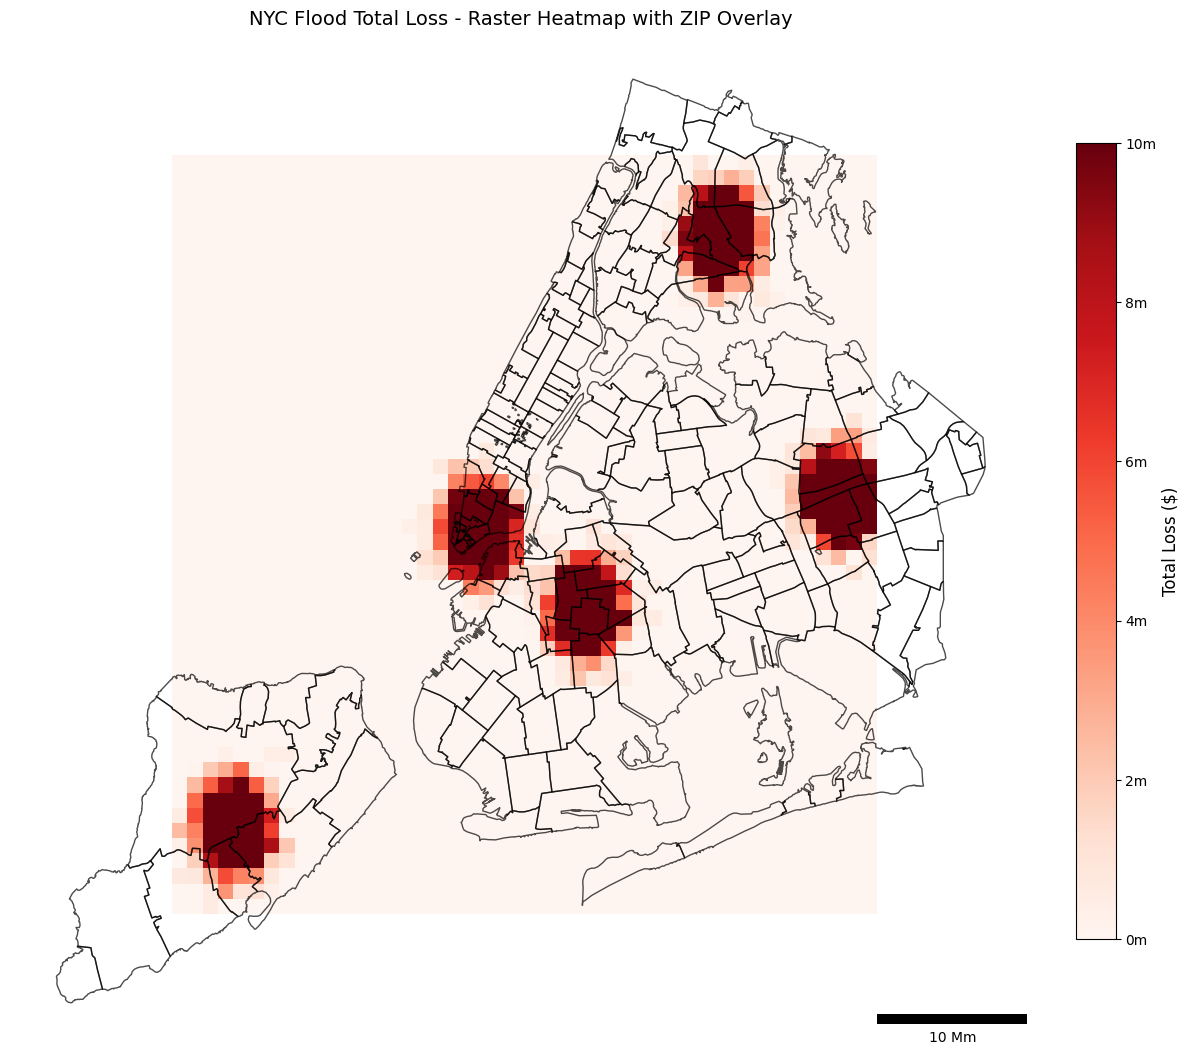

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from rasterio.transform import from_origin
!pip install matplotlib-scalebar
from matplotlib_scalebar.scalebar import ScaleBar

# Set raster resolution (1 km grid)
resolution = 1000  # in meters
xmin, ymin, xmax, ymax = gdf.total_bounds
width = int((xmax - xmin) / resolution)
height = int((ymax - ymin) / resolution)
raster = np.zeros((height, width))

# Aggregate raster by summing losses into grid cells
for _, row in gdf.iterrows():
    col = int((row.geometry.x - xmin) / resolution)
    row_idx = int((ymax - row.geometry.y) / resolution)
    if 0 <= col < width and 0 <= row_idx < height:
        raster[row_idx, col] += row[loss_column]

# Define raster transform and extent
transform = from_origin(xmin, ymax, resolution, resolution)
extent = [xmin, xmax, ymin, ymax]

# Plot raster with ZIP outlines
fig, ax = plt.subplots(figsize=(12, 12))

# Set fixed color range
vmin = 0
vmax = 10_000_000

# Plot using imshow so we can attach a proper colorbar
im = ax.imshow(raster, extent=extent, origin='upper', cmap='Reds', vmin=vmin, vmax=vmax)

# Add formatted colorbar
cbar = fig.colorbar(im, ax=ax, fraction=0.036, pad=0.04)
cbar.set_label('Total Loss ($)', fontsize=12)
cbar.ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x/1e6:.0f}m'))

# Overlay ZIP outlines
zip_gdf.boundary.plot(ax=ax, linewidth=1, edgecolor="black", alpha=0.7)

# Add scale bar (1 pixel = 1000 meters)
scalebar = ScaleBar(dx=1000, units="m", location='lower right', box_alpha=0.5)
ax.add_artist(scalebar)

# Final labels
ax.set_title(f"NYC Flood {loss_column} - Raster Heatmap with ZIP Overlay", fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()


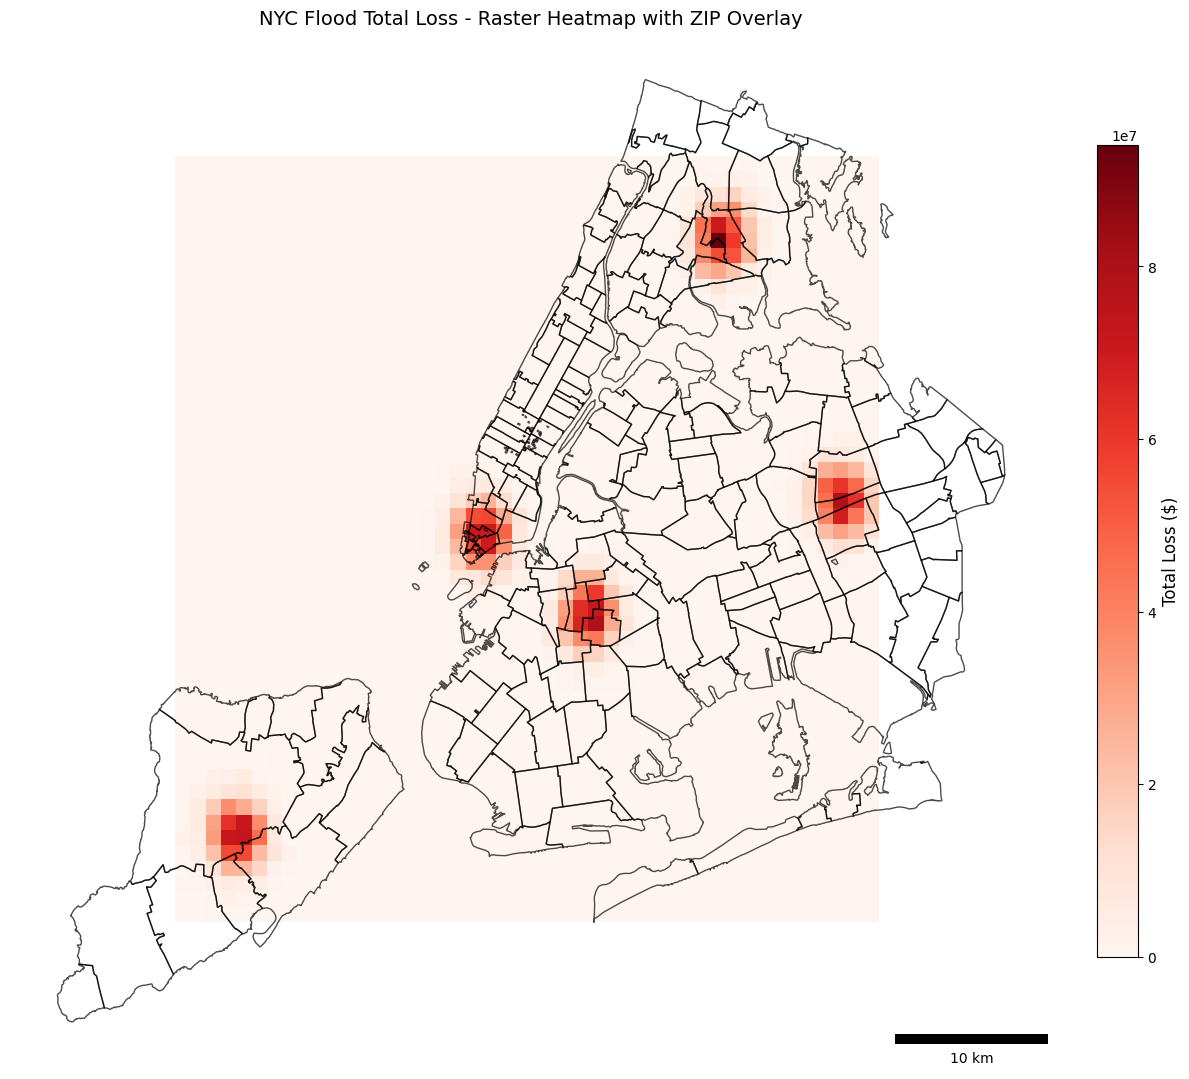

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from rasterio.transform import from_origin
from rasterio.plot import show
from matplotlib_scalebar.scalebar import ScaleBar

# Set raster resolution (1 km grid)
resolution = 1000  # in meters
xmin, ymin, xmax, ymax = gdf.total_bounds
width = int((xmax - xmin) / resolution)
height = int((ymax - ymin) / resolution)
raster = np.zeros((height, width))

# Aggregate raster by summing losses into grid cells
for _, row in gdf.iterrows():
    col = int((row.geometry.x - xmin) / resolution)
    row_idx = int((ymax - row.geometry.y) / resolution)
    if 0 <= col < width and 0 <= row_idx < height:
        raster[row_idx, col] += row[loss_column]

# Define transform for the raster
transform = from_origin(xmin, ymax, resolution, resolution)

# Plot raster with ZIP outlines
fig, ax = plt.subplots(figsize=(12, 12))

# Display the raster heatmap
# Note: 'show' returns the image object which we can use to add a colorbar
image = show(raster, transform=transform, ax=ax, cmap='Reds')

# Add colorbar with label
# Since 'show' uses matplotlib's imshow under the hood, we can retrieve the image from the axis
im = ax.get_images()[0]
cbar = fig.colorbar(im, ax=ax, fraction=0.036, pad=0.04)
cbar.set_label('Total Loss ($)', fontsize=12)

# Overlay ZIP outlines
zip_gdf.boundary.plot(ax=ax, linewidth=1, edgecolor="black", alpha=0.7)

# Add scale bar
scalebar = ScaleBar(dx=1, units="m", location='lower right', box_alpha=0.5)
ax.add_artist(scalebar)

# Set title and remove axes
ax.set_title(f"NYC Flood {loss_column} - Raster Heatmap with ZIP Overlay", fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()


In [19]:
print(df.columns)
print(df['ZIP'].head())
print(zip_gdf.columns)

Index(['Event ID', 'Date', 'City', 'ZIP', 'Latitude', 'Longitude',
       'Hazard Type', 'Time', 'Policyholders', 'Claim References',
       'Building Loss', 'Contents Loss', 'Basement/Foundation Loss',
       'Elevator/Utility Loss', 'Total Loss'],
      dtype='object')
0    11519
1    11509
2    11210
3    10448
4    11150
Name: ZIP, dtype: int64
Index(['OBJECTID', 'postalCode', 'PO_NAME', 'STATE', 'borough', 'ST_FIPS',
       'CTY_FIPS', 'BLDGpostalCode', 'Shape_Leng', 'Shape_Area', '@id',
       'geometry'],
      dtype='object')


<Axes: >

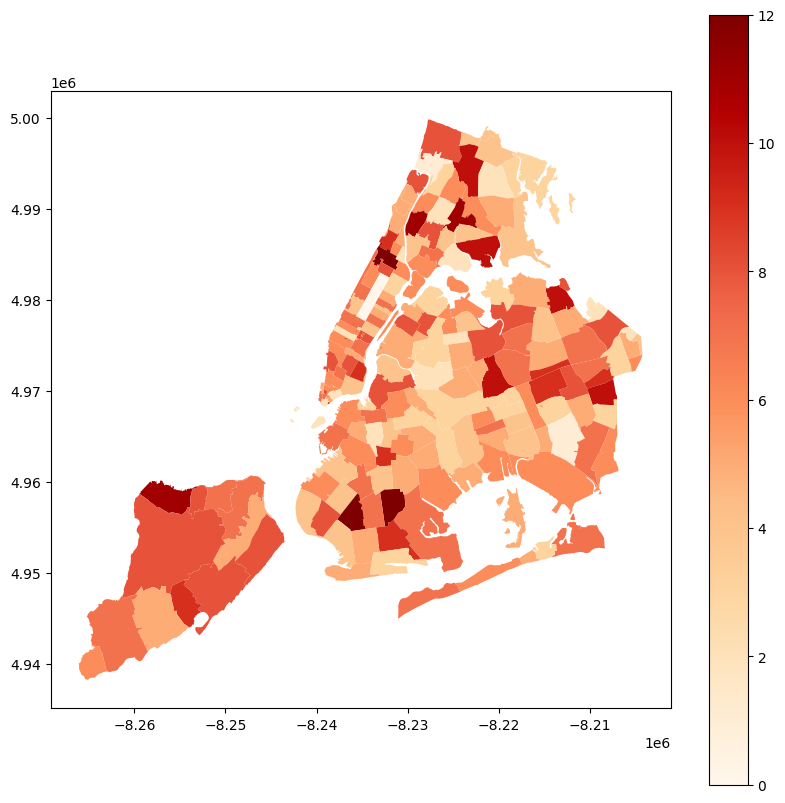

In [20]:
# 3. Choropleth Map With 
# Make sure both ZIP columns are strings to match properly
df['ZIP'] = df['ZIP'].astype(str)
zip_gdf['postalCode'] = zip_gdf['postalCode'].astype(str)

# Step 1: Group CAT events by ZIP
event_counts_by_zip = df.groupby('ZIP').size().reset_index(name='event_count')

# Step 2: Merge ZIP shapefile with event counts
zip_merged = zip_gdf.merge(event_counts_by_zip, how='left', left_on='postalCode', right_on='ZIP')

# Step 3: Fill missing ZIPs with 0 event counts (optional but useful for plotting)
zip_merged['event_count'] = zip_merged['event_count'].fillna(0)

# Step 4: Plot the choropleth map
zip_merged.plot(column='event_count', cmap='OrRd', legend=True, figsize=(10, 10))
